# Masking Land Cover with Geodatacoast

## Load packages

In [1]:
import datacube
from datacube.utils import masking 
from odc.ui import with_ui_cbk
import matplotlib.pyplot as plt
import xarray as xr
from scipy import ndimage
import numpy as np
from datacube.utils import cog


import sys
sys.path.insert(1, '../Tools/')
from datacube.utils.cog import write_cog
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.landcover import plot_land_cover
from dea_tools.spatial import xr_rasterize

## Load data

In [2]:
# connect to datacube
dc = datacube.Datacube(app="")

In [14]:
# define central coords for area of interest
# area_name = 'southern_vic'
# point_x, point_y =(-38.9452, 146.2559)
# area_name = 'port_lincoln'
# point_x, point_y =(-34.7597, 136.1591)
area_name = 'wa-coast'
point_x, point_y =(-25.7405, 113.2086)

# select sise of area (check on map below that you are happy with extent before proceeding)
lat = (point_x-0.3, point_x+0.3)
lon = (point_y-0.3, point_y+0.3)

# display AOI on map
display_map(x=lon, y=lat)

In [15]:
# specify the parameters to pass to the load query
query = {
    "x": lon,
    "y": lat,
    "output_crs": "EPSG:3577",
    'resolution': (-25, 25),
    "group_by": "solar_day",
    }

# load geocoast data
geodatacoast = dc.load(product="geodata_coast_100k",
         **query)

# load land cover data 
landcover = dc.load(product="ga_ls_landcover_class_cyear_2", measurements='level4', time ='2020',
         **query)

## Define the mask.

For reference, in the geodata_coast_100k layer: 
* 0 = ocean
* 1 = island
* 2 = mainland


### Binary dilation

In [16]:
# 1 represents ocean and 0 represent land
mask_land_0 = xr.ones_like(landcover.level4).where(geodatacoast.land.isel(time=0) < 1, 0)

# 0 represents ocean and 1 represent land
mask_land_1 = xr.ones_like(landcover.level4).where(geodatacoast.land.isel(time=0) >= 1, 0)

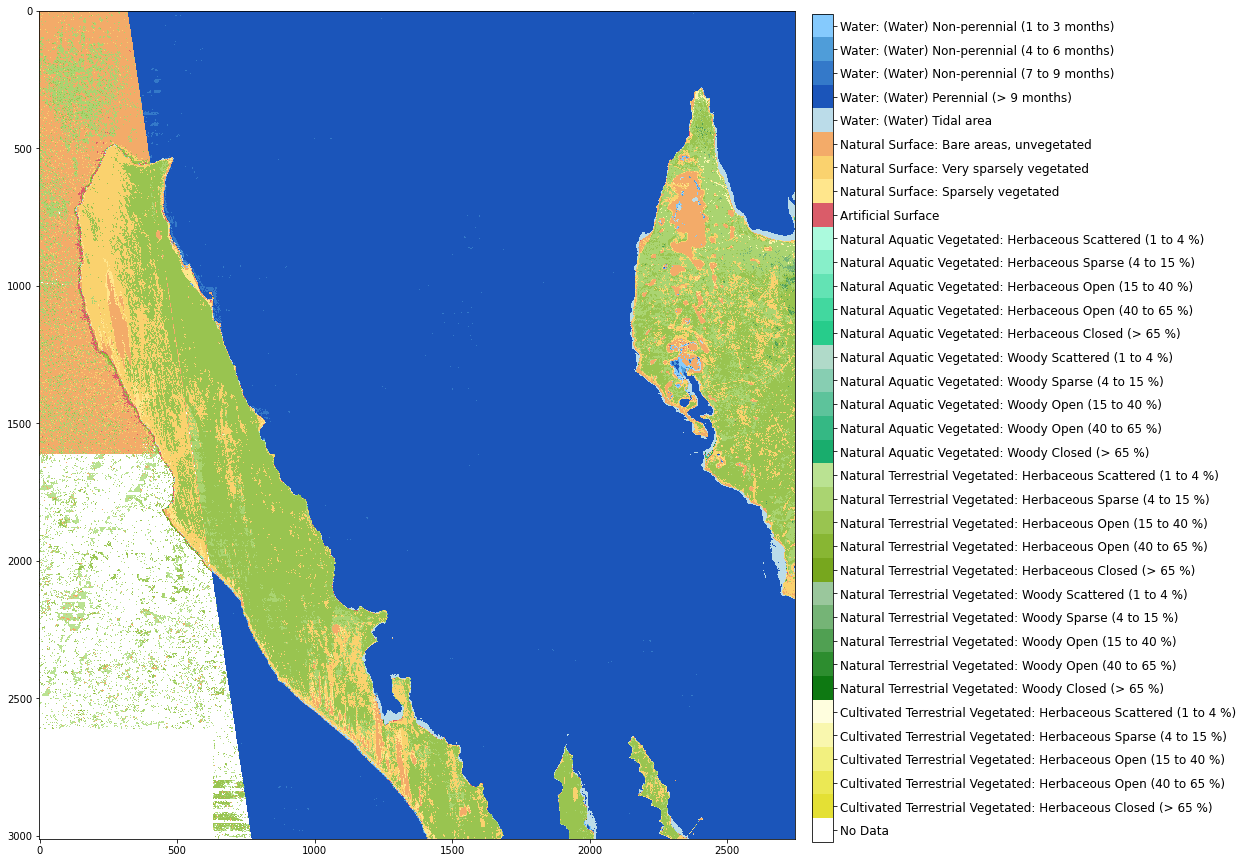

In [17]:
plot_land_cover(landcover.level4, measurement='level4', year='2010')

### buffer, no dilation 

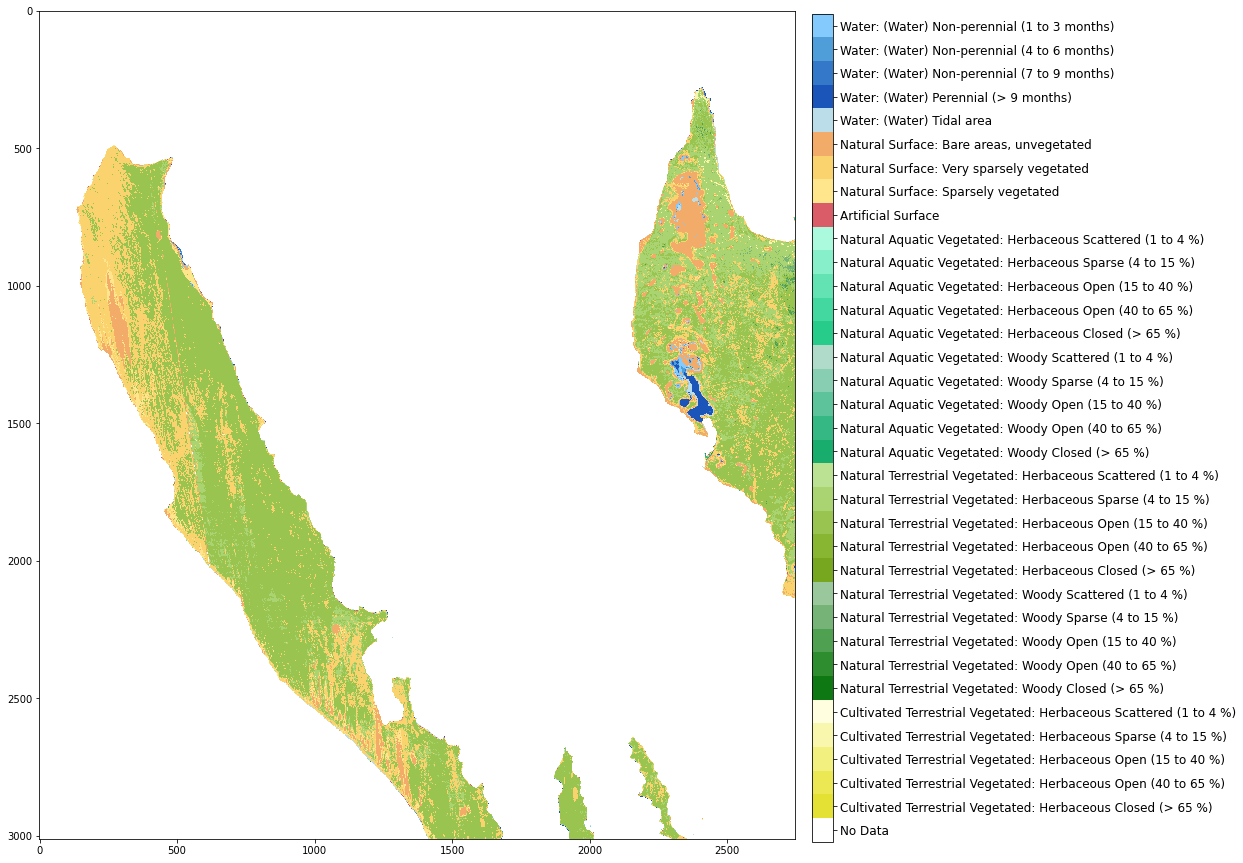

In [29]:
# apply mask
landcover['masked_level4'] = xr.DataArray(np.where(mask_land_1, landcover.level4, np.zeros_like(landcover.level4)), dims=('time', 'y', 'x'))
# plot
plot_land_cover(landcover.masked_level4, measurement='level4', year='2010')

### 1km buffer 

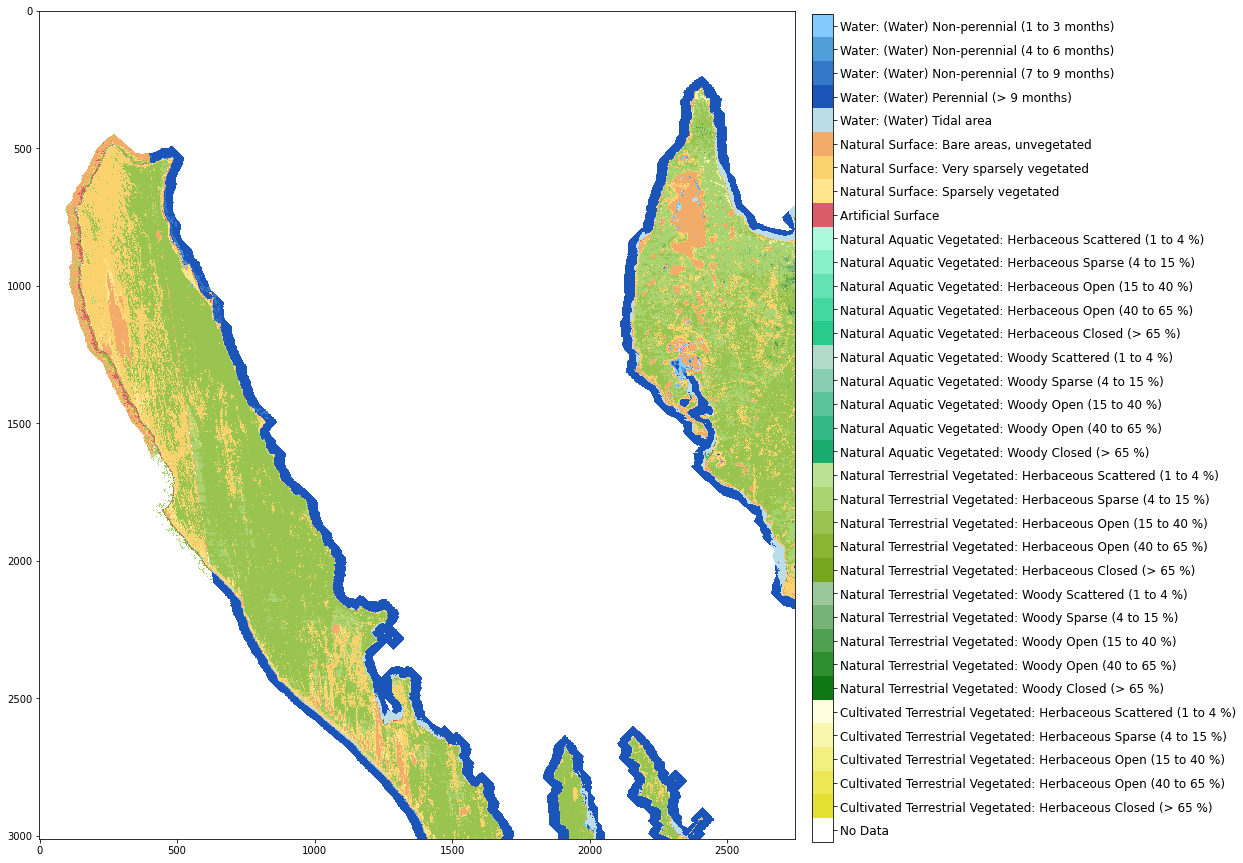

In [22]:
#remove time dimmesion by selecting first time index. make it an xarray for easy plotting
bindilation_buff = xr.DataArray(np.flipud(ndimage.binary_dilation(mask_land_1, iterations=40)))
# apply mask
landcover['masked_level4_1km'] = xr.DataArray(np.where(bindilation_buff, landcover.level4, np.zeros_like(landcover.level4)), dims=('time', 'y', 'x'))
# plot
plot_land_cover(landcover.masked_level4_1km, measurement='level4', year='2010')

### 5km buffer

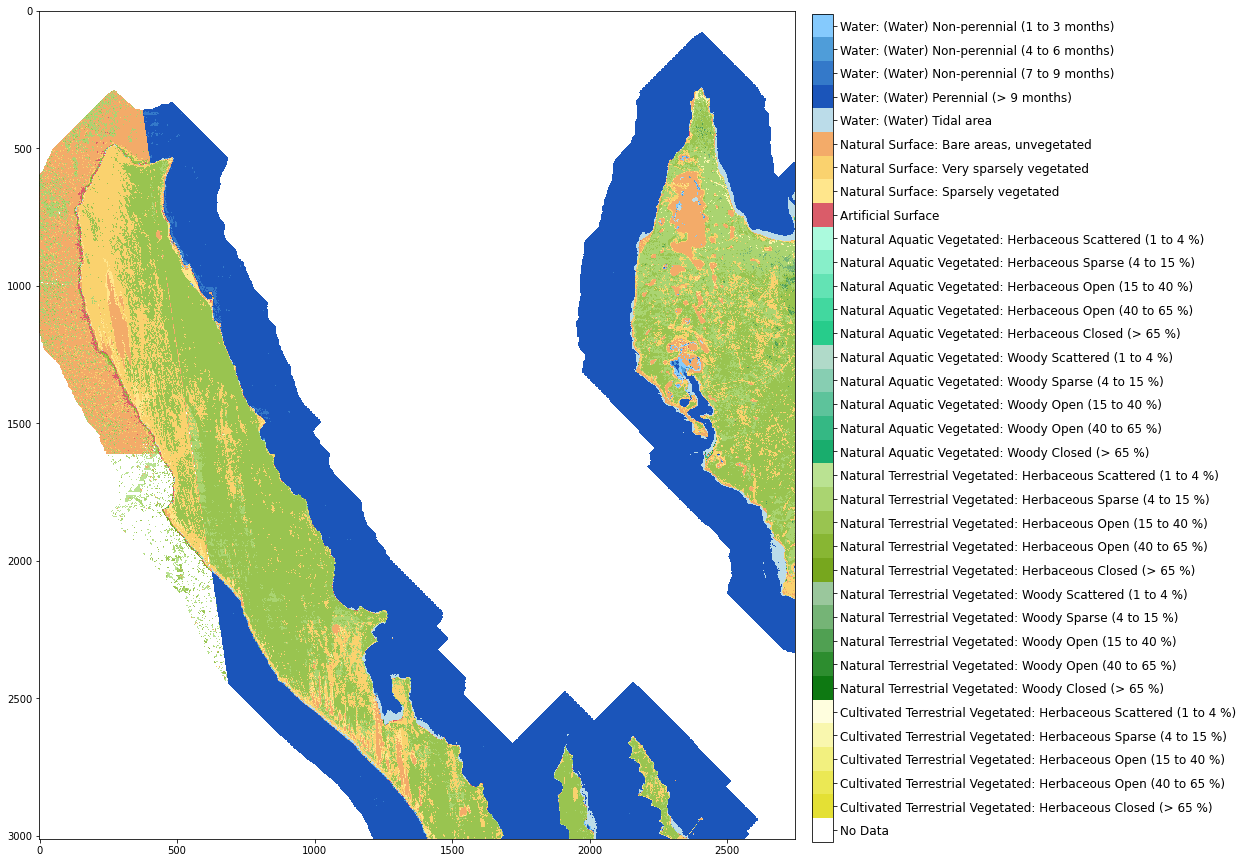

In [23]:
#remove time dimmesion by selecting first time index. make it an xarray for easy plotting
bindilation_buff = xr.DataArray(np.flipud(ndimage.binary_dilation(mask_land_1, iterations=200)))
# apply mask
landcover['masked_level4_5km'] = xr.DataArray(np.where(bindilation_buff, landcover.level4, np.zeros_like(landcover.level4)), dims=('time', 'y', 'x'))
# plot
plot_land_cover(landcover.masked_level4_5km, measurement='level4', year='2010')

### 10km buffer

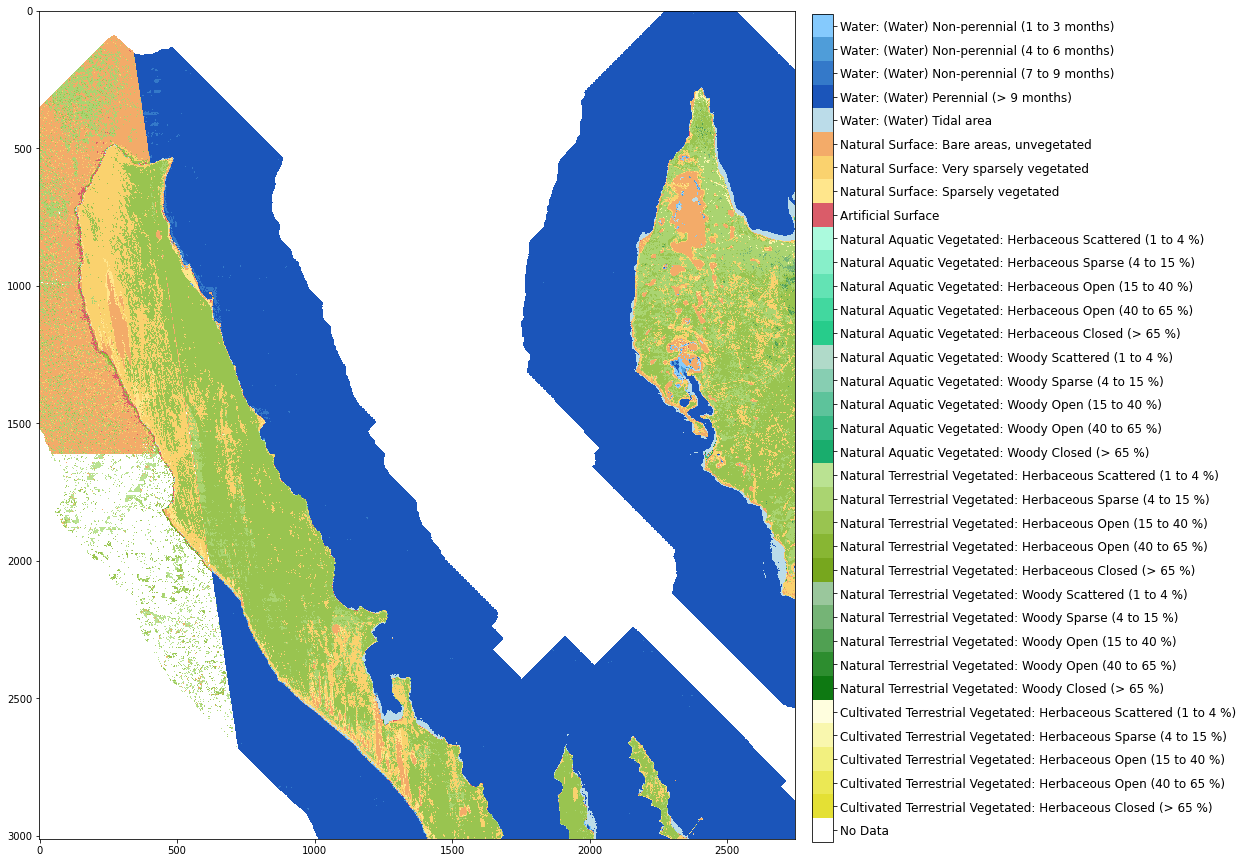

In [20]:
#remove time dimmesion by selecting first time index. make it an xarray for easy plotting
bindilation_buff = xr.DataArray(np.flipud(ndimage.binary_dilation(mask_land_1, iterations=400)))
# apply mask
landcover['masked_level4_10km'] = xr.DataArray(np.where(bindilation_buff, landcover.level4, np.zeros_like(landcover.level4)), dims=('time', 'y', 'x'))
# plot
plot_land_cover(landcover.masked_level4_10km, measurement='level4', year='2010')

In [30]:
cog.write_cog(landcover.level4, f'{area_name}_unbuffed.tif', overwrite=True)
cog.write_cog(landcover.level4.masked_level4, f'{area_name}_unbuffed.tif', overwrite=True)
cog.write_cog(landcover.masked_level4_1km, f'{area_name}_1kmbuffed.tif', overwrite=True)
cog.write_cog(landcover.masked_level4_5km, f'{area_name}_5kmbuffed.tif', overwrite=True)
cog.write_cog(landcover.masked_level4_10km, f'{area_name}_10kmbuffed.tif', overwrite=True)